### Imports

In [60]:
# External modules
import numpy as np
import tensortools as tt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Internal modules
from config import default_dataset
from logger import logger
from constants import *
from utils import *
from batchutils import *
from fileops import load_conditioned_dataset, get_data_root, get_output_equivalent

# Initialize empty figures dictionary
figs = {}

# Get conditioned data root 
dataroot = get_output_equivalent(get_data_root(), 'raw', 'conditioned')

### Input datasets and main processing parameters

In [36]:
# Input parameters
analysis_type = DEFAULT_ANALYSIS  # analysis type
mouseline = 'line3'  # default_dataset['mouseline']  # mouse line
expdate = '20191112'  # default_dataset['expdate']  # experiment date
mouseid = 'mouse12'  # default_dataset['mouseid']  # mouse number
region = 'region1'  # default_dataset['region']  # brain region
layer = None  # cortical layer

# Processing parameters
global_correction = GLOBAL_CORRECTION  # global stack correction method
kalman_gain = KALMAN_GAIN  # Gain of Kalman filter
neuropil_scaling_coeff = NEUROPIL_SCALING_COEFF  # scaling coefficient for neuropil subtraction
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile for baseline computation
baseline_wquantile = BASELINE_WQUANTILE  # quantile filter window size (s) to compute fluorescence baseline
baseline_wsmoothing = BASELINE_WSMOOTHING  # gaussian filter window size (s) to smooth out fluorescence baseline

### Load data

In [37]:
# Construct input data directory from input and processing parameters
if isinstance(global_correction, dict):
    global_correction = global_correction[mouseline]
prepro_id = get_prepro_id(global_correction=global_correction, kalman_gain=kalman_gain)
baseline_id = get_baseline_id(baseline_quantile, baseline_wquantile, baseline_wsmoothing)
s2p_id = get_s2p_id()
conditioning_id = f'alpha{neuropil_scaling_coeff}_{baseline_id}'
datadir = os.path.join(dataroot, conditioning_id, s2p_id, prepro_id, analysis_type, mouseline)
if not os.path.isdir(datadir):
    logger.error(f'No conditioned data found in {datadir}')
    raise FileNotFoundError(f'"{datadir}" directory does not exist')

# Re-construct dataset filename from input parameters
dataset_id = f'{expdate}_{mouseid}_{region}'
dataset_fname = f'{dataset_id}.h5'
dataset_fpath = os.path.join(datadir, dataset_fname)
if not os.path.isfile(dataset_fpath):
    raise FileNotFoundError(f'"{dataset_fpath}" file does not exist')

# Load conditioned dataset
logger.info(f'Loading conditioned dataset from {dataset_fpath}')
xtimeseries, popagg_timeseries, output_info_table, ROI_masks = load_conditioned_dataset(dataset_fpath)

 2024/03/20 15:29:12: Loading conditioned dataset from /gpfs/scratch/lemait01/data/usnm/conditioned/alpha0.7_qadaptive_wq30.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap_0<-1_9->10every100/main/line3/20191112_mouse12_region1.h5
 2024/03/20 15:29:12: loading experiment info table...
 2024/03/20 15:29:12: loading conditioned timeseries data...
 2024/03/20 15:29:13: loading conditioned population-average timeseries data...
 2024/03/20 15:29:13: loading ROI masks...
 2024/03/20 15:29:13: data successfully loaded


### Extract array from data 

In [38]:
logger.info(f'data dimensions: {describe_dataframe_index(xtimeseries)}')
arr = mux_series_to_array(xtimeseries[Label.ZSCORE])

 2024/03/20 15:29:26: data dimensions: 444 ROIs x 15 runs x 16 trials x 100 frames


### Apply PCA

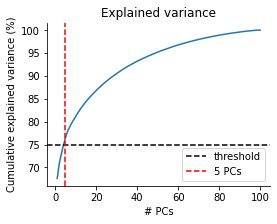

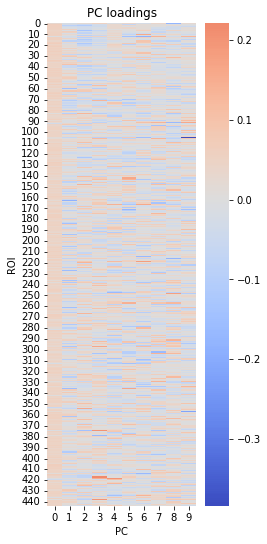

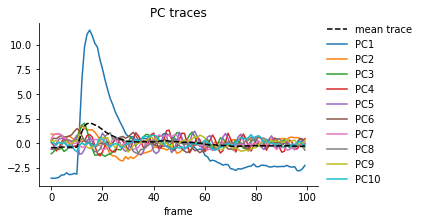

In [168]:
# Compute trial-aggregated data
trialagg_arr = np.median(arr, axis=2)

# Aggregate across conditions
agg_arr = np.median(trialagg_arr, axis=1)
agg_arr = trialagg_arr[:, 6, :]

# Transpose to get (n_components, n_observations) array
agg_arr = agg_arr.T

# Apply min-max scaling
scaler = MinMaxScaler()
agg_arr_scaled = scaler.fit_transform(agg_arr)

# Fit PCA model to the data
pca = PCA()
pca.fit(agg_arr_scaled)

# Plot % explained variance vs number of PCs
cumvar = np.cumsum(pca.explained_variance_ratio_)
fig, ax = plt.subplots(figsize=(4, 3))
sns.despine(ax=ax)
ax.set_title('Explained variance')
ax.set_xlabel('# PCs')
ax.set_ylabel('Cumulative explained variance (%)')
ax.plot(np.arange(cumvar.size) + 1, cumvar * 100)

# Identify the number of PCs to keep based on a threshold of explained variance
cumvar_thr = 0.75
ax.axhline(cumvar_thr * 100, c='k', ls='--', label=f'threshold')
nPCs = np.where(cumvar > cumvar_thr)[0][0] + 1
ax.axvline(nPCs, c='r', ls='--', label=f'{nPCs} PCs')
ax.legend()

# Re-fit PCA model with appropriate number of PCs
pca.set_params(n_components=10)
pca.fit(agg_arr_scaled)

# Extract and plot the ROI loadings (weights) of each PC
loadings = pca.components_.T
nROIs, nPCs = loadings.shape
fig, ax = plt.subplots(figsize=(nPCs / 3, nROIs / 50))
sns.heatmap(loadings, ax=ax, center=0, cmap='coolwarm')
ax.set_xlabel('PC')
ax.set_ylabel('ROI')
ax.set_title('PC loadings')

# Transform data with PCA model
PC_traces = pca.transform(agg_arr_scaled).T

# Plot PC traces (along with mean trace)
fig, ax = plt.subplots(figsize=(5, 3))
ax.set_title('PC traces')
ax.set_xlabel('frame')
sns.despine(ax=ax)
ax.plot(agg_arr.mean(axis=1), c='k', ls='--', label='mean trace', zorder=10)
for i, trace in enumerate(PC_traces):
    ax.plot(trace, label=f'PC{i + 1}')
ax.legend(frameon=False, bbox_to_anchor=(1, 0.5), loc='center left');

### Apply tensor decomposition

In [194]:
# Tensor decomposition parameters
ranks = np.arange(10) + 1  # model ranks (i.e. number of components) to be tested
nreplicates = 4  # number of replicates per rank
fit_method = 'ncp_hals'  # fitting method : 
# (non-negative) CP decomposition with Hierarcial Alternating Least Squares (HALS) optimization

# Fit tensor decomposition model
# cond_arr = arr[:, 6, :, :]
ensemble = tt.Ensemble(fit_method=fit_method)
ensemble.fit(arr, ranks=ranks.tolist(), replicates=nreplicates)

Rank-1 models:  min obj, 0.94;  max obj, 0.94;  time to fit, 2.4s


Rank-2 models:  min obj, 0.91;  max obj, 0.92;  time to fit, 10.6s


Rank-3 models:  min obj, 0.89;  max obj, 0.90;  time to fit, 15.9s


Rank-4 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 26.7s


Rank-5 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 14.0s


Rank-6 models:  min obj, 0.84;  max obj, 0.85;  time to fit, 17.5s


Rank-7 models:  min obj, 0.83;  max obj, 0.83;  time to fit, 25.8s


Rank-8 models:  min obj, 0.82;  max obj, 0.82;  time to fit, 21.2s


Rank-9 models:  min obj, 0.81;  max obj, 0.81;  time to fit, 36.9s


Rank-10 models:  min obj, 0.80;  max obj, 0.80;  time to fit, 24.1s


### Plot model ensemble convergence

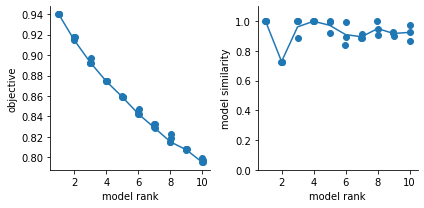

In [195]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
sns.despine(fig=fig)
tt.plot_objective(ensemble, ax=axes[0])   # plot reconstruction error as a function of num components.
tt.plot_similarity(ensemble, ax=axes[1])  # plot model similarity as a function of num components.
fig.tight_layout()

### Plot model factors

 2024/03/20 18:02:32: plotting factors for rank 1...
 2024/03/20 18:02:33: plotting factors for rank 2...
 2024/03/20 18:02:33: plotting factors for rank 3...
 2024/03/20 18:02:34: plotting factors for rank 4...


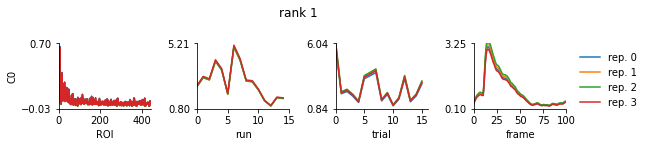

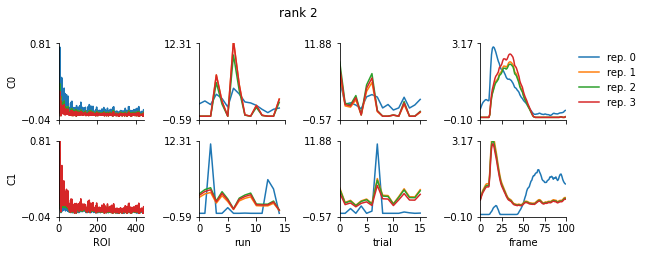

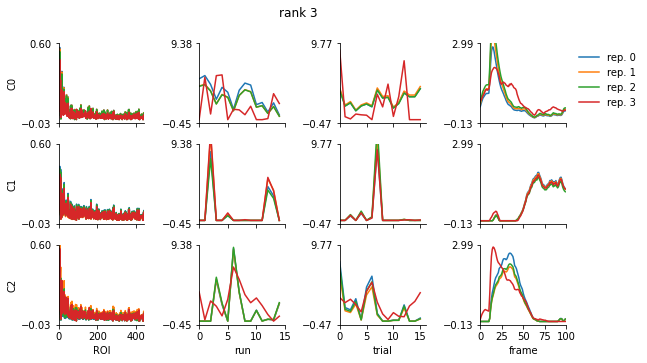

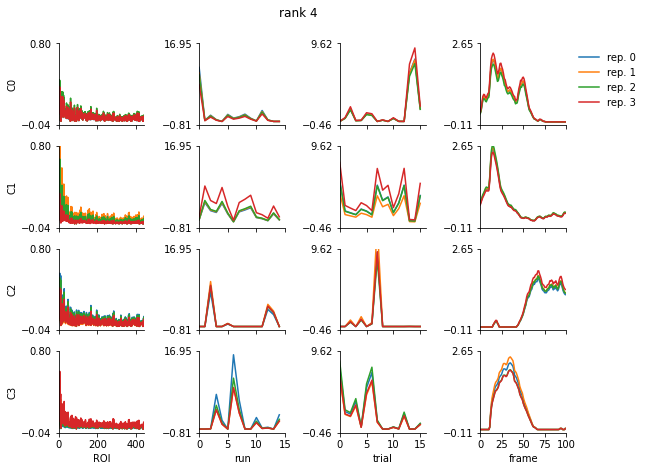

In [196]:
def plot_factors(ensemble, rank=None, max_rank=4):
    '''
    Plot low-dimensional factors for model replicates

    :param ensemble: tensortools.Ensemble
    :param rank: int, rank of the model to plot. if None, plot all ensemble ranks
    :return: figure handle(s)
    '''
    # If rank not provided, extract list of ranks from ensemble
    if rank is None:
        rank = list(ensemble.results.keys())
    # If rank is iterable
    if is_iterable(rank):
        rank = rank[:max_rank]
        # If more than 1 rank, plot factors for each rank and return list of figures
        if len(rank) > 1:
            return [plot_factors(ensemble, rank=r) for r in rank]
        # If only 1 rank, extract first element
        else:
            rank = rank[0]

    logger.info(f'plotting factors for rank {rank}...')

    # Extract factors for the given rank, and tensor order
    factors = ensemble.factors(rank)
    ndims = factors[0].ndim

    # Create figure and axes
    fig, axes = plt.subplots(rank, ndims, figsize=(2 * ndims, 1.5 * rank))
    axes = np.atleast_2d(axes)

    # Plot factors for each replicate
    for ireplicate, factors in enumerate(factors):
        tt.plot_factors(factors, fig=fig, line_kw=dict(label=f'rep. {ireplicate}'))

    # Adjust figure layout
    fig.suptitle(f'rank {rank}', y=1 + 0.2 / rank)
    for i, ax in enumerate(axes[:, 0]):
        ax.set_ylabel(f'C{i}')
    for ax, lbl in zip(axes[-1, :], xtimeseries.index.names):
        ax.set_xlabel(lbl)
    # for ax in axes.flatten():
    #     ax.autoscale(axis='y')
    axes[0, -1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

    # Return figure handle
    return fig

# Plot the low-d factors for each rank
fig = plot_factors(ensemble, rank=ranks)